# Generate simulated data

In this notebook we generate a simulated dataset based on experimental data. 
- The maps are directly extracted from the experimental data.
- The phases (or spectra) are built using chemical composition extracted from the literature (citations to be included)

The output of this notebook is put in the `generated_datasets` 

## Imports

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# esmpy imports
from esmpy.datasets.generate_weights import generate_weights, chemical_maps_weights
from esmpy.datasets.generate_EDXS_phases import generate_random_phases, unique_elts, generate_modular_phases
from esmpy.datasets.base import generate_dataset
from esmpy.utils import arg_helper
from esmpy.conf import DEFAULT_SYNTHETIC_DATA_DICT, BASE_PATH

# Generic imports 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import hyperspy.api as hs



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate weights

We use an experimental dataset to create realistic abundance maps. Theses maps are based from chemical mapping of the dataset.

/home/adrien/anaconda3/envs/esmpy/lib/python3.10/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/home/adrien/anaconda3/envs/esmpy/lib/python3.10/site-packages/hyperspy/io.py:560: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


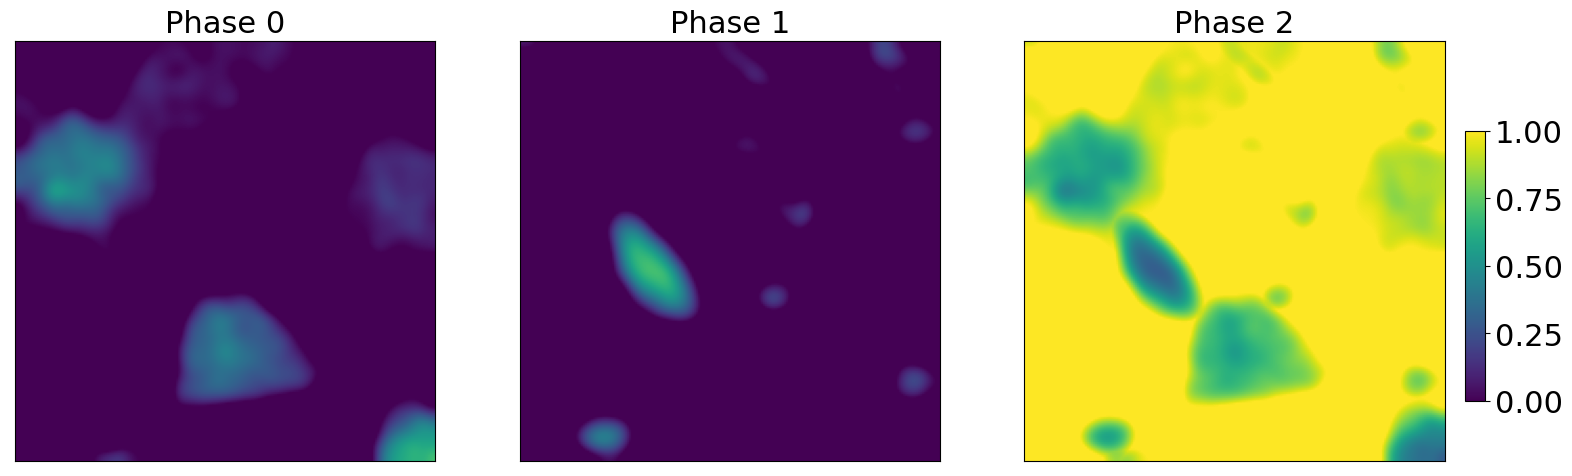

In [14]:
# Path of the experimental dataset
path = BASE_PATH.parent / Path("experiments/71GPa_experimental_data.hspy")

# Creation of the weights
weights = chemical_maps_weights(path,["Fe_Ka","Ca_Ka"],conc_max = 0.7)

### Plot the results

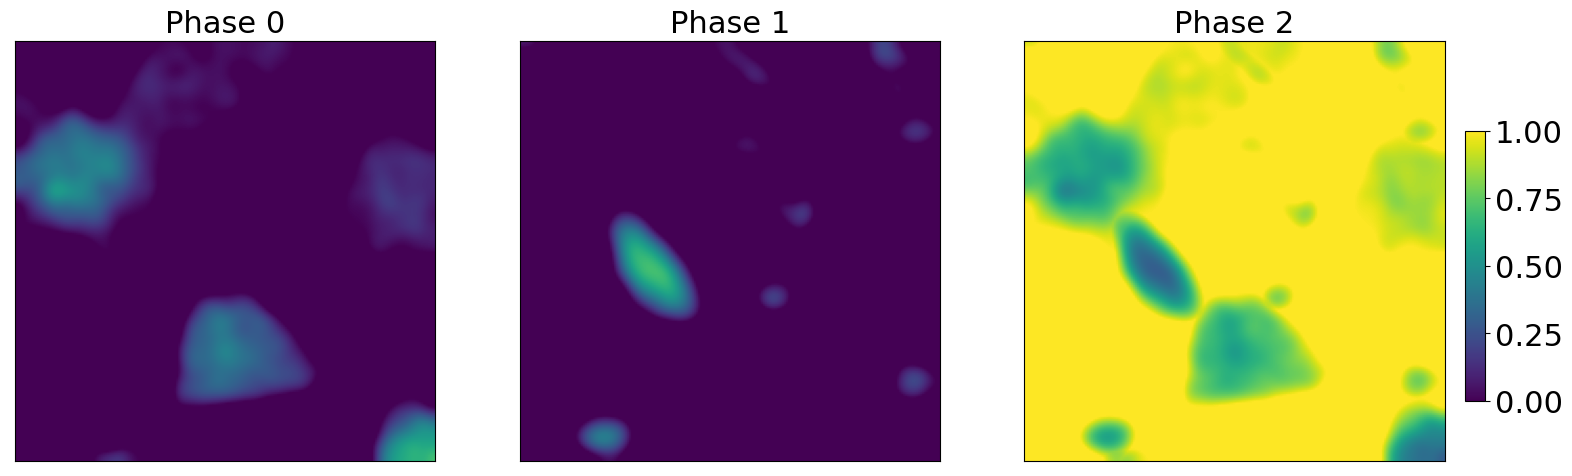

In [18]:
fig,axs = plt.subplots(1,3,figsize = (20,20*3))
for j in range(axs.shape[0]) :
    im = axs[j].imshow(weights[:,:,j],vmin = 0, vmax = 1.0)
    axs[j].tick_params(axis = "both",width = 0,labelbottom = False,labelleft = False) 
    axs[j].set_title("Phase {}".format(j),fontsize = 22)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.47, 0.01, 0.045])
fig.colorbar(im,cax=cbar_ax)
cbar_ax.tick_params(labelsize=22)

# Generate phases

We generate phases based on values extracted from the literature. The phases we try to simulate here are Ferropericlase, Bridgmanite and Ca-perovskite.

## Model parameters

We use dictionnaries to input the modelling parameters.

In [15]:
# Elemental concetration of each phase
elts_dicts = [
    # Pseudo ferropericlase
    {
        "Mg" : 0.522, "Fe" : 0.104, "O" : 0.374, "Cu" : 0.05
    },
    # Pseudo Ca-Perovskite
    {
        "Mg" : 0.020, "Fe" : 0.018, "Ca" : 0.188, "Si" : 0.173, "Al" : 0.010, "O" : 0.572, "Ti" : 0.004, "Cu" : 0.05, "Sm" : 0.007, "Lu" : 0.006, "Nd" : 0.006 
    },
    # Pseudo Bridgmanite
    {
        "Mg" : 0.445, "Fe" : 0.035, "Ca" : 0.031, "Si" : 0.419, "Al" : 0.074, "O" : 1.136, "Cu" : 0.05, "Hf" : 0.01
    }]

# Parameters of the bremsstrahlung
brstlg_pars = [
    {"b0" : 0.0001629, "b1" : 0.0009812},
    {"b0" : 0.0007853, "b1" : 0.0003658},
    {"b0" : 0.0003458, "b1" : 0.0006268}
]

# Model parameters : energy scale, detector broadening, x-ray emission database, beam energy, absorption parameters, detector efficiency
model_params = {
        "e_offset" : 0.3,
        "e_size" : 1980,
        "e_scale" : 0.01,
        "width_slope" : 0.01,
        "width_intercept" : 0.065,
        "db_name" : "default_xrays.json",
        "E0" : 200,
        "params_dict" : {
            "Abs" : {
                "thickness" : 100.0e-7,
                "toa" : 35,
                "density" : 4.5,
                "atomic_fraction" : False
            },
            "Det" : "SDD_efficiency.txt"
        }
    }

# miscellaneous paramaters : average detected number of X-rays per pixel, phases densities, output folder, model name, random seed
data_dict = {
    "N" : 100,
    "densities" : [1.2,1.0,0.8],
    "data_folder" : "71GPa_synthetic_N100",
    "model" : "EDXS",
    "seed" : 42
}

## Generate phases

In [20]:
phases, full_dict = generate_modular_phases(
    elts_dicts=elts_dicts, brstlg_pars = brstlg_pars,
    scales = [1, 1, 1],
    model_params= model_params,
    seed = 42
    )
# scales : bremsstrahlung parameters modifiers

# Finish building the dictionnary of the simulation
data_dict.update(full_dict)

### Plot the results

Text(0.5, 0, 'Energy loss (eV)')

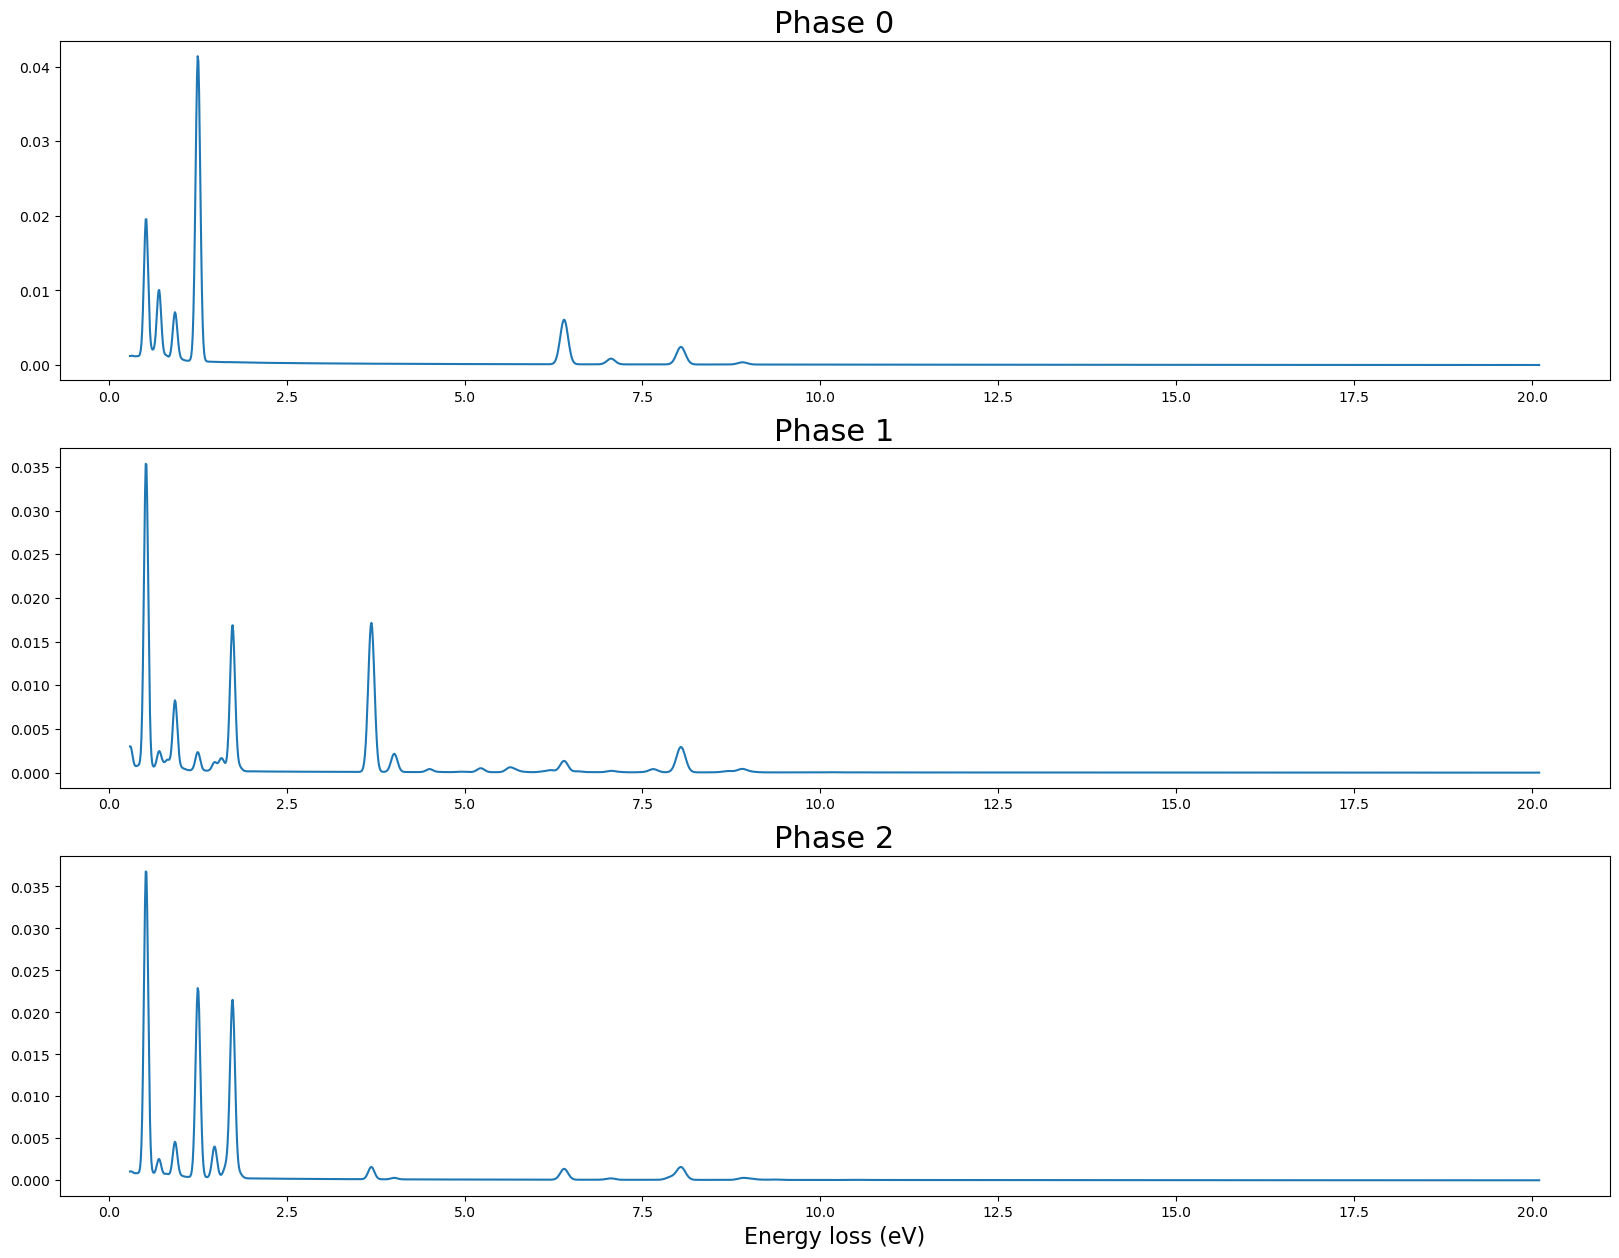

In [19]:
fig,axs = plt.subplots(3,1,figsize = (20,15))

# Build the energy scale
x = np.linspace(
    full_dict["model_parameters"]["e_offset"],
    full_dict["model_parameters"]["e_offset"]+full_dict["model_parameters"]["e_scale"]*full_dict["model_parameters"]["e_size"],
    num=full_dict["model_parameters"]["e_size"])

for j in range(axs.shape[0]) :
    axs[j].plot(x,phases[j])
    axs[j].set_title("Phase {}".format(j),fontsize = 22)

axs[-1].set_xlabel("Energy loss (eV)",fontsize = 16)

## Generate the data

It will produce 5 spectrum images in the target folder.

In [17]:
generate_dataset(seeds_range=5, **data_dict, weights=weights)

100%|██████████| 5/5 [00:21<00:00,  4.21s/it]
